## Flow/Speed/Occupancy Clustering Exploration

### Purpose & Motivation

The traffic data provides three distinct dimensions: flow, occupancy, and speed.  Using these three features, it may be possible to classify traffic into three distinct states: normal flow, degraded flow, and traffic jam.

### Hypothesis

We can classify the traffic data (flow, occupancy, and speed) using a clustering algorithm.

### Tasks/Questions to Answer

#### Questions to Answer
1. How data look?
2. How effective are different clustering algorithms?
3. Which clustering method appears best?

#### Tasks
1. Visualize the traffic data
2. Apply a series of clustering algorithms and visualize the result
3. Analyze the visualizations

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import gzip
import datetime as dt
from os import listdir
from os.path import isfile, join
import time

import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_validation import train_test_split

/Users/multidest/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
meta_path = "../data/External/meta/2015/d11/"
data_5min_path = "../data/External/station_5min/2015/d11/"

In [3]:
onlyfiles = [f for f in listdir(data_5min_path) if isfile(join(data_5min_path, f))]

onlyfiles[0]

'd11_text_station_5min_2015_01_01.txt.gz'

In [4]:
colnames = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', 
            '% Observed', 'TotalFlow', 'AvgOccupancy', 'AvgSpeed', 'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

### Find some healthy sensors

In [5]:
def count_bad_sensors(df):
    count_nan_df = df
    count_nan_df.loc[:,'Station'] = count_nan_df['Station'].astype(str)
    count_nan_df = count_nan_df[['Station','Timestamp','TotalFlow','AvgOccupancy','AvgSpeed']]
    num = count_nan_df._get_numeric_data()
    num[num > 0] = 0
    count_nan_df=count_nan_df.replace(np.nan,1)
    count_nan_df=count_nan_df.groupby('Station').sum().reset_index()
    count_nan_df.loc[:,'Total'] = count_nan_df['TotalFlow']+count_nan_df['AvgOccupancy']+count_nan_df['AvgSpeed']
    count_nan_df=count_nan_df.sort_values('Total')
    return count_nan_df

In [6]:
def calc_avg_obs(df):
    count_nan_df = df
    count_nan_df['Station'] = count_nan_df['Station'].astype(str)
    count_nan_df = count_nan_df[['Station','% Observed']]
    count_nan_df=count_nan_df.groupby('Station').mean().reset_index()
    return count_nan_df

### Look at one month's worth of data

In [7]:
df_list = []
t0 = time.time()
for i, filename in enumerate(onlyfiles):
    t1 = time.time()
    with gzip.open(data_5min_path+filename, 'rb') as f:
        file_content = pd.read_csv(f,header=None,names=colnames)
        df_list.append(file_content)
    t2 = time.time()
    print "[{0}]: {1}, {2:.3} sec".format( i, filename, t2-t1 )
    if i == 30:
        break
print "Total time: {:.3} min".format( (time.time()-t0)/60 )

[0]: d11_text_station_5min_2015_01_01.txt.gz, 2.11 sec
[1]: d11_text_station_5min_2015_01_02.txt.gz, 2.02 sec
[2]: d11_text_station_5min_2015_01_03.txt.gz, 1.99 sec
[3]: d11_text_station_5min_2015_01_04.txt.gz, 1.97 sec
[4]: d11_text_station_5min_2015_01_05.txt.gz, 2.37 sec
[5]: d11_text_station_5min_2015_01_06.txt.gz, 2.39 sec
[6]: d11_text_station_5min_2015_01_07.txt.gz, 2.39 sec
[7]: d11_text_station_5min_2015_01_08.txt.gz, 2.27 sec
[8]: d11_text_station_5min_2015_01_09.txt.gz, 2.41 sec
[9]: d11_text_station_5min_2015_01_10.txt.gz, 2.37 sec
[10]: d11_text_station_5min_2015_01_11.txt.gz, 2.23 sec
[11]: d11_text_station_5min_2015_01_12.txt.gz, 2.33 sec
[12]: d11_text_station_5min_2015_01_13.txt.gz, 2.09 sec
[13]: d11_text_station_5min_2015_01_14.txt.gz, 2.0 sec
[14]: d11_text_station_5min_2015_01_15.txt.gz, 2.16 sec
[15]: d11_text_station_5min_2015_01_16.txt.gz, 2.14 sec
[16]: d11_text_station_5min_2015_01_17.txt.gz, 2.12 sec
[17]: d11_text_station_5min_2015_01_18.txt.gz, 2.47 sec
[18

In [8]:
big_df = pd.concat(df_list)

big_df.shape

(13204512, 52)

#### Grab CA-54 (E &W) ML only

In [9]:
df_54 = big_df[ (big_df['Lane Type']=='ML') & (big_df['Freeway #']==54) ]

df_54.shape

(53568, 52)

#### Grab CA-94 (E &W) ML only 

In [10]:
df_94 = big_df[ (big_df['Lane Type']=='ML') & (big_df['Freeway #']==94) ]

df_94.shape

(330336, 52)

In [11]:
#sensor_results = count_bad_sensors(big_df).reset_index(drop=True)
sensor_results = count_bad_sensors( df_54 ).reset_index(drop=True)

/Users/multidest/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Split timestamp into date, time

In [12]:
daymap = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

def add_date_time_weekday( df ):
    df.loc[:,'Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.loc[:,'Time'] = df['Timestamp'].apply(lambda x:x.time())
    df.loc[:,'Date'] = df['Timestamp'].apply(lambda x:x.date())
    df.loc[:,'Weekday'] = df['Date'].apply( lambda x: daymap[x.weekday()] )

In [13]:
t0 = time.time()
add_date_time_weekday( df_54 )
print "Total time: {:.3} min".format( (time.time()-t0)/60 )

/Users/multidest/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


Total time: 0.26 min


In [14]:
t0 = time.time()
add_date_time_weekday( df_94 )
print "Total time: {:.3} min".format( (time.time()-t0)/60 )

Total time: 1.7 min


In [16]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

default_lims={
    'x1': (0, 0.2), 'y1': (40, 75),
    'x2': (0, 600), 'y2': (0, 0.7),
    'x3': (0, 600), 'y3': (40, 75)
}

def plot_triple( df, title, setlims=True, lims=default_lims ):
    fig = plt.figure(figsize = (20,5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    plt.title(title,{'fontsize': 20})
    ax3 = fig.add_subplot(1, 3, 3)
    
    ax1.plot(df.AvgOccupancy,df.AvgSpeed,'g.')
    ax2.plot(df.TotalFlow,df.AvgOccupancy,'b.')
    ax3.plot(df.TotalFlow,df.AvgSpeed,'r.')
    
    if setlims == True:
        ax1.set_xlim( lims['x1'] ), ax1.set_ylim( lims['y1'] )
        ax2.set_xlim( lims['x2'] ), ax2.set_ylim( lims['y2'] )
        ax3.set_xlim( lims['x3'] ), ax3.set_ylim( lims['y3'] )
        
        #ax1.set_xlim( (0, 0.2)), ax1.set_ylim( (40, 75))
        #ax2.set_xlim( (0, 600)), ax2.set_ylim( (0, 0.7))
        #ax3.set_xlim( (0, 600)), ax3.set_ylim( (40, 75))
    
    ax1.set_xlabel('AvgOccupancy'), ax1.set_ylabel('AvgSpeed')
    ax2.set_xlabel('TotalFlow'), ax2.set_ylabel('AvgOccupancy')
    ax3.set_xlabel('TotalFlow'), ax3.set_ylabel('AvgSpeed')
    plt.show()

#### Look at mean values

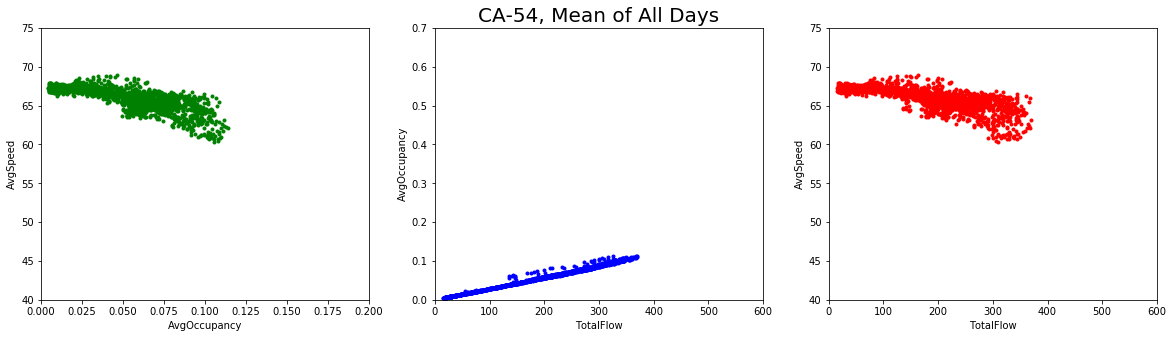

In [17]:
df_mean = df_54.groupby(['Weekday', 'Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
df_mean.reset_index( inplace=True )

plot_triple( df_mean, "CA-54, Mean of All Days")

#### Exploratory scatter plots

/Users/multidest/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


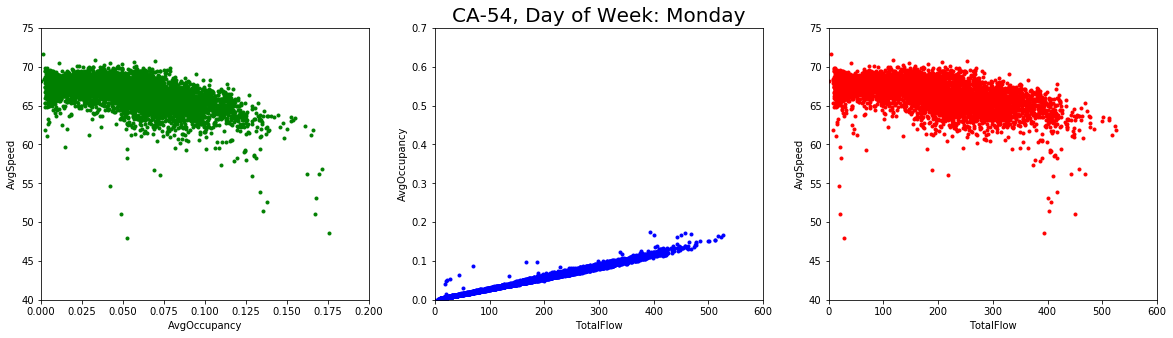

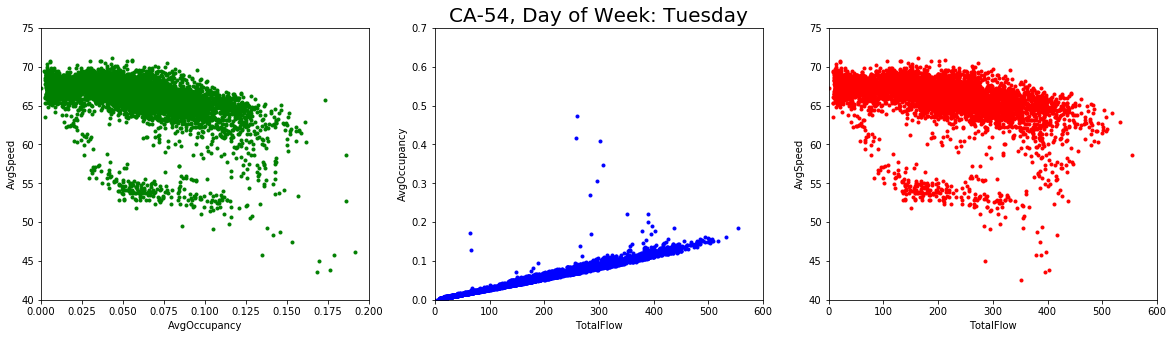

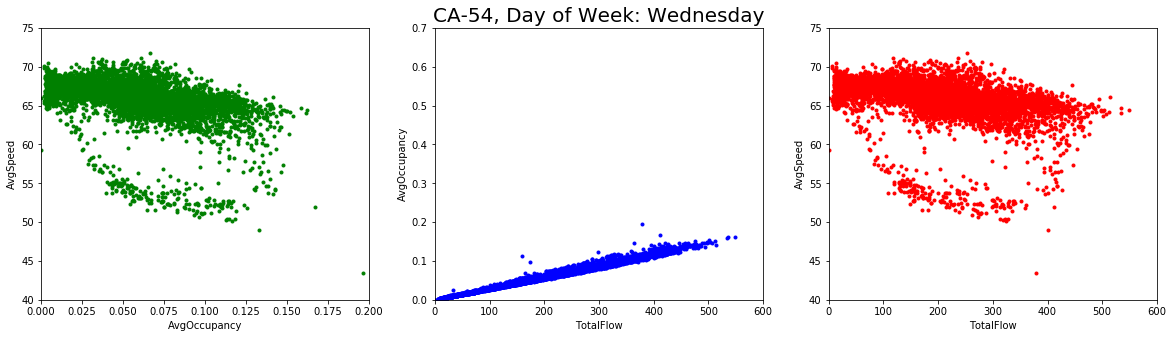

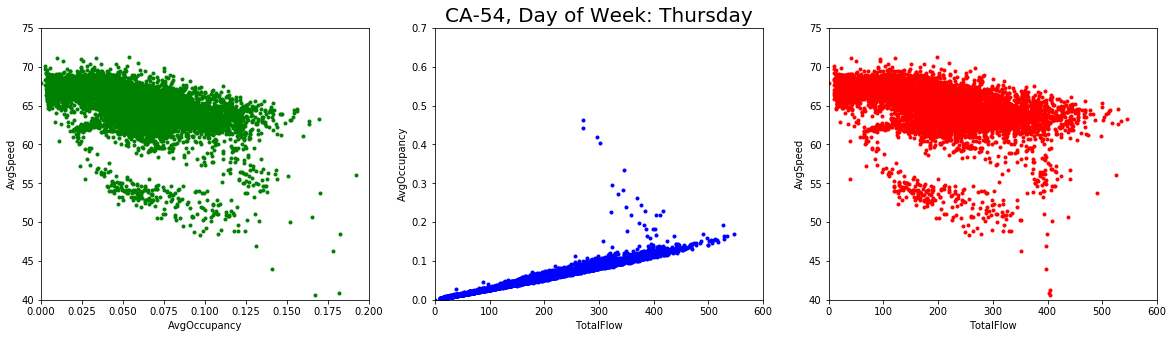

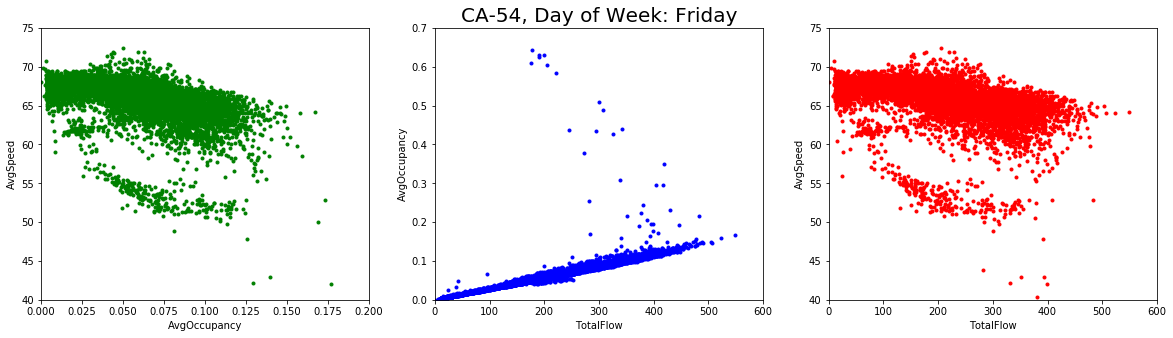

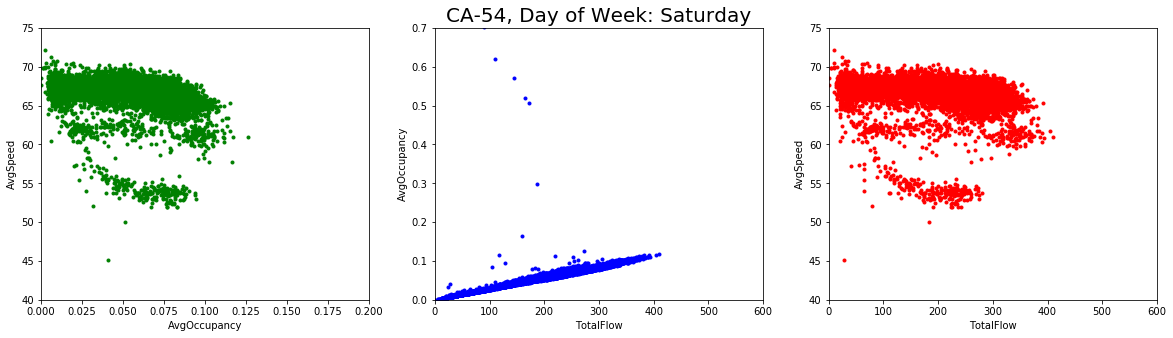

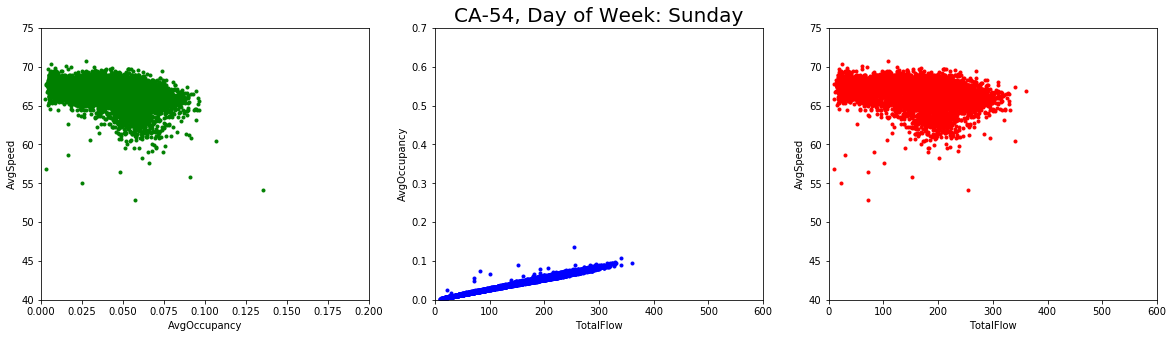

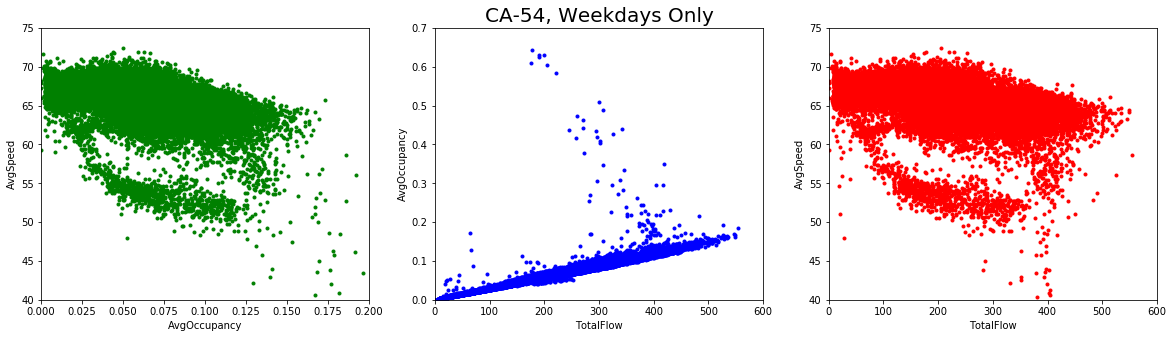

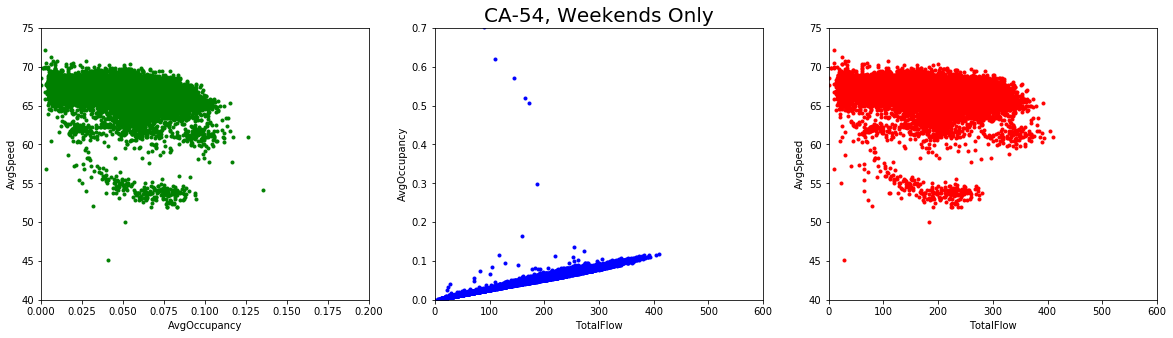

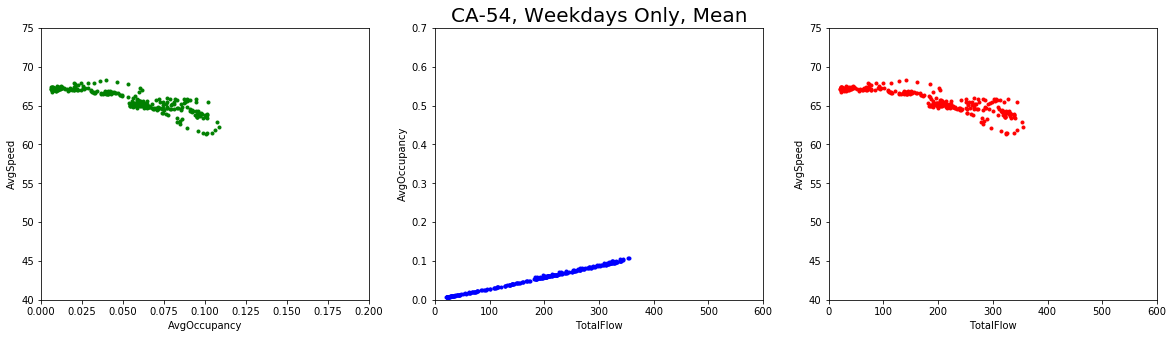

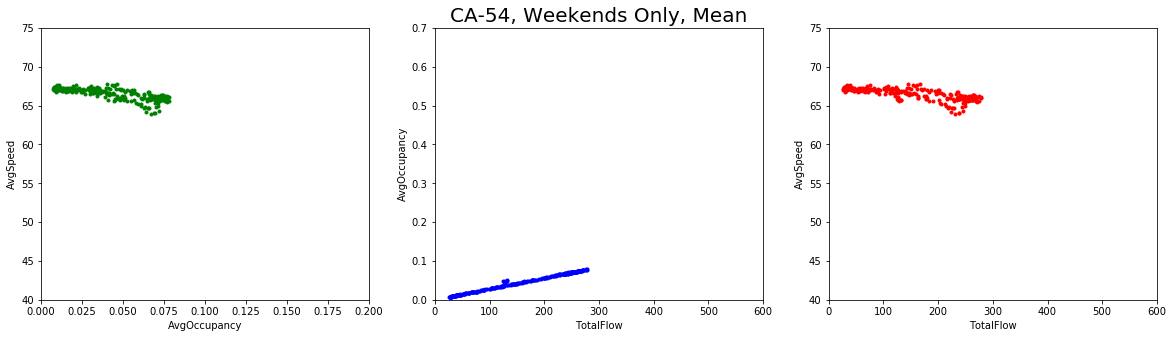

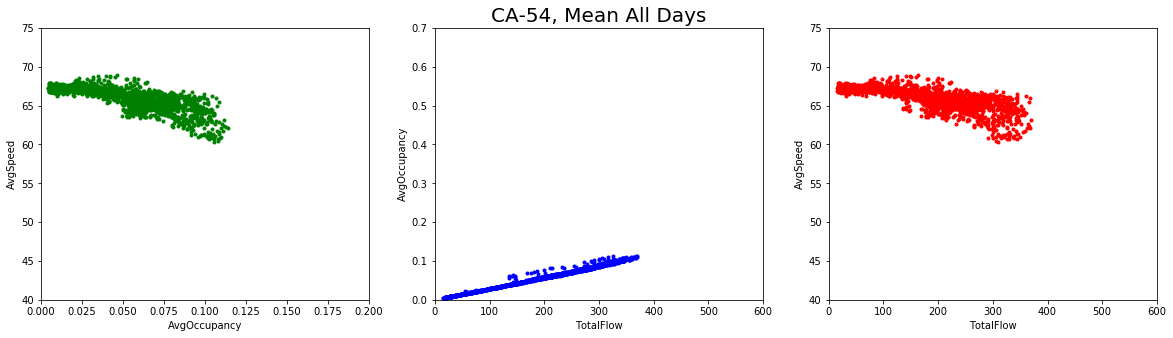

In [18]:
for d in daymap.values():
    small_df = df_54.ix[df_54.Weekday==d,['TotalFlow','AvgOccupancy','AvgSpeed']]
    plot_triple( small_df, 'CA-54, Day of Week: {}'.format(d) )

small_df = df_54[ df_54.Weekday.isin(weekdays) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-54, Weekdays Only' )
    
small_df = df_54[ df_54.Weekday.isin(weekends) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-54, Weekends Only' )

small_df = df_54[ df_54.Weekday.isin(weekdays) ].groupby(['Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-54, Weekdays Only, Mean' )

small_df = df_54[ df_54.Weekday.isin(weekends) ].groupby(['Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-54, Weekends Only, Mean' )

plot_triple( df_mean, 'CA-54, Mean All Days' )

/Users/multidest/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


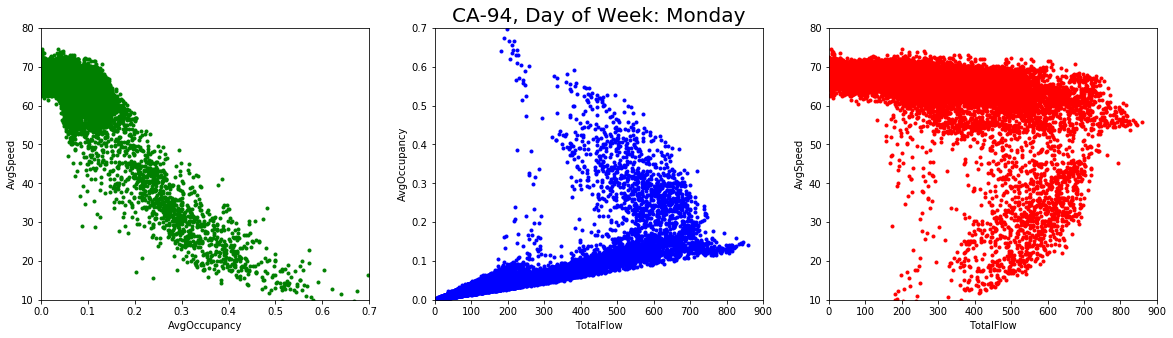

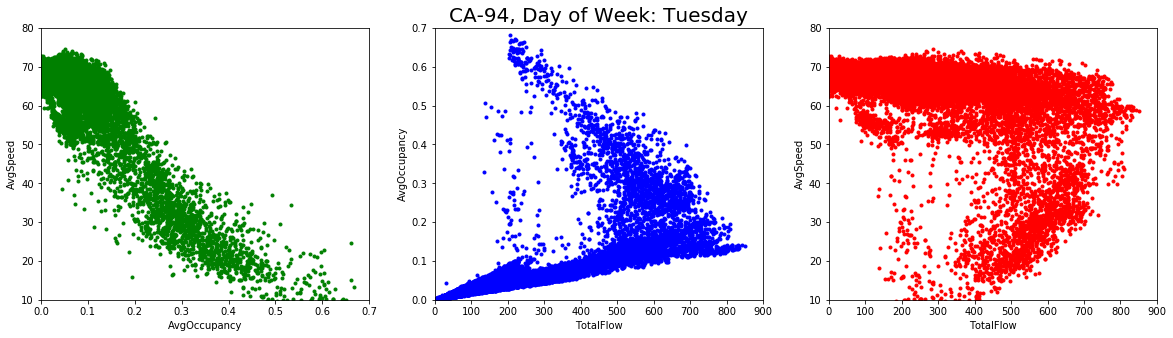

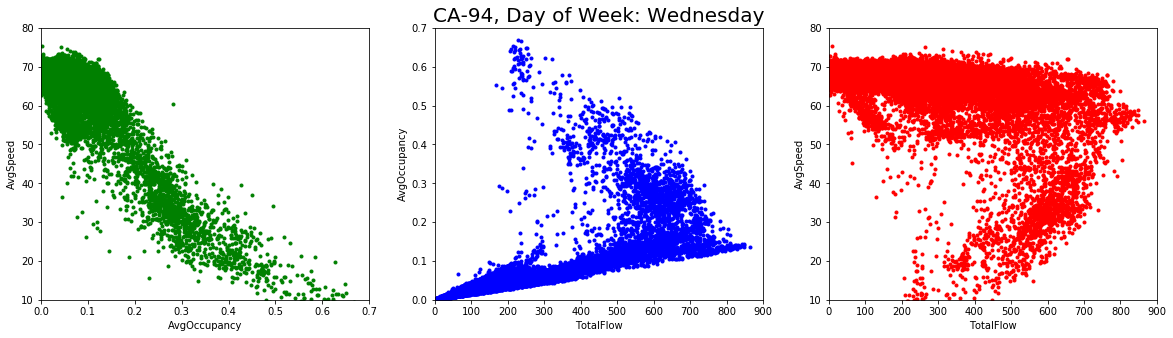

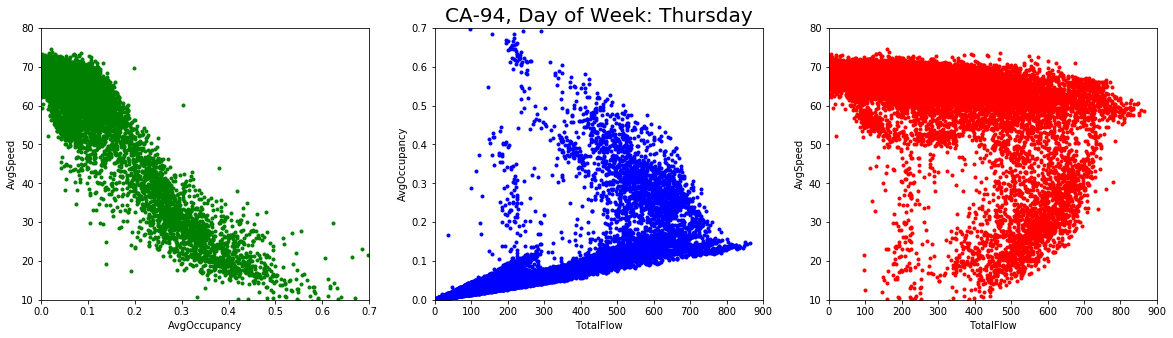

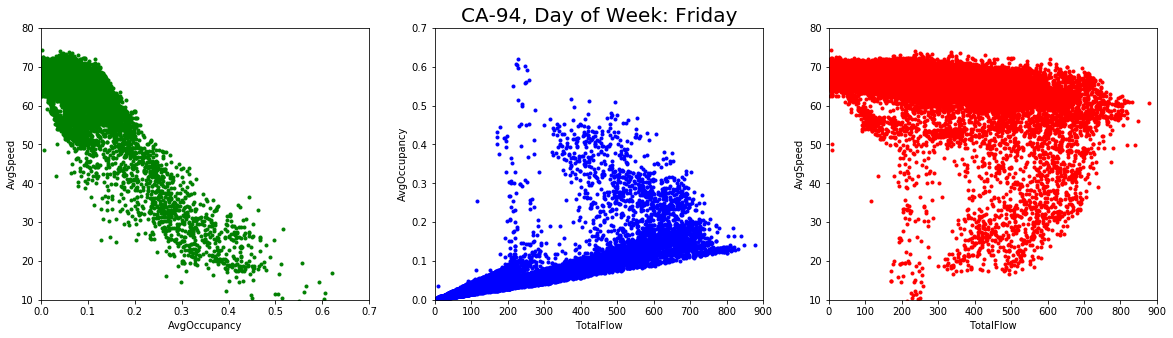

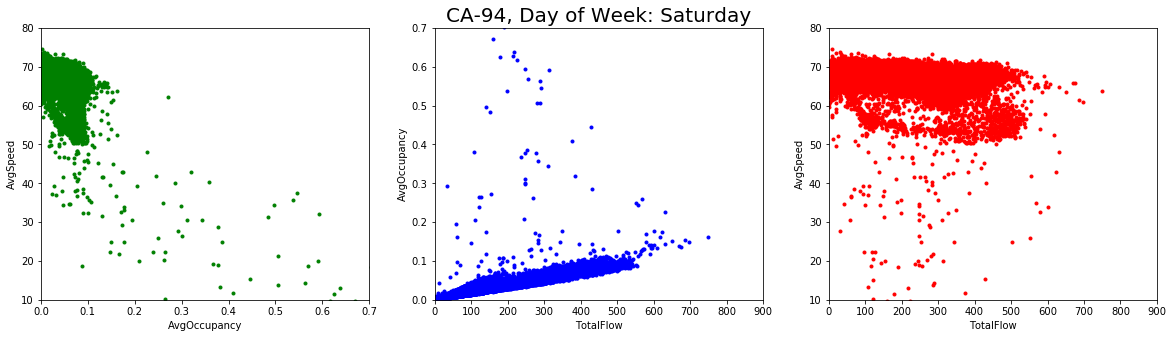

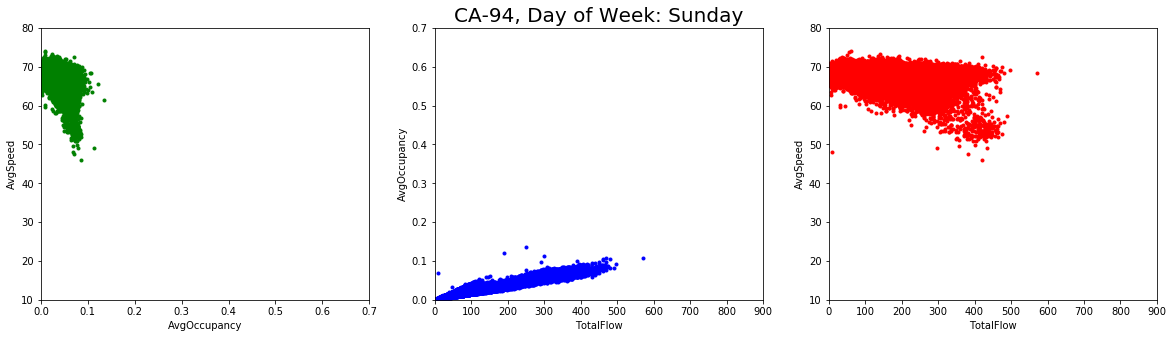

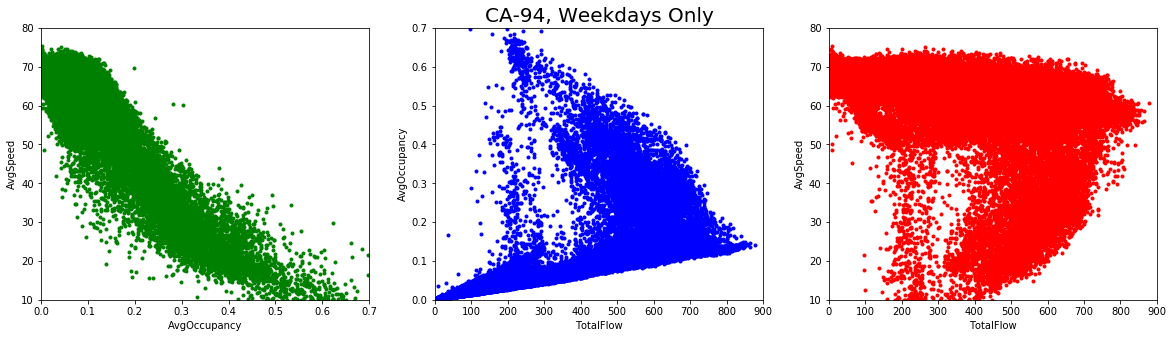

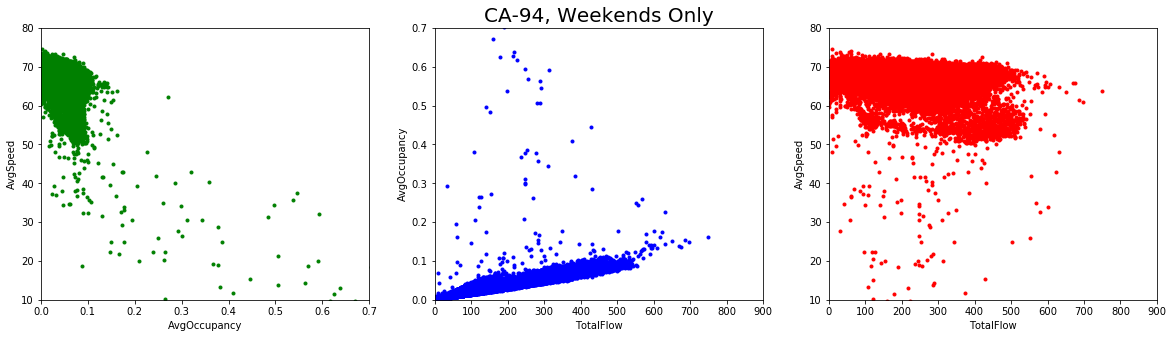

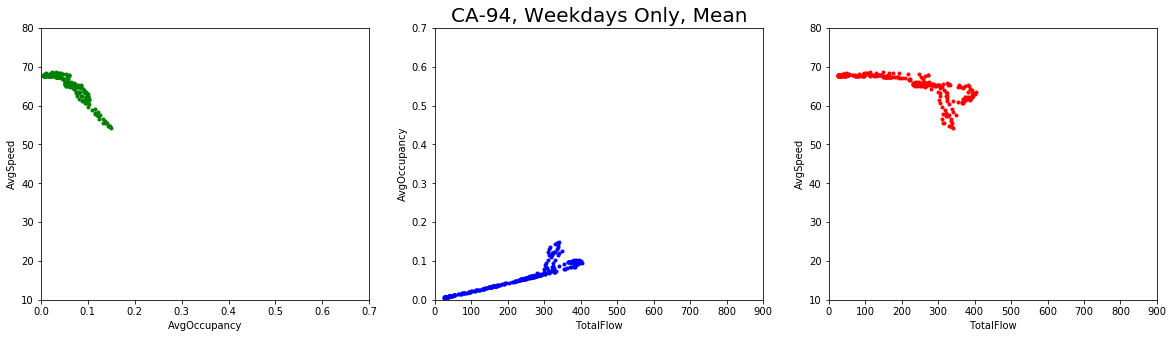

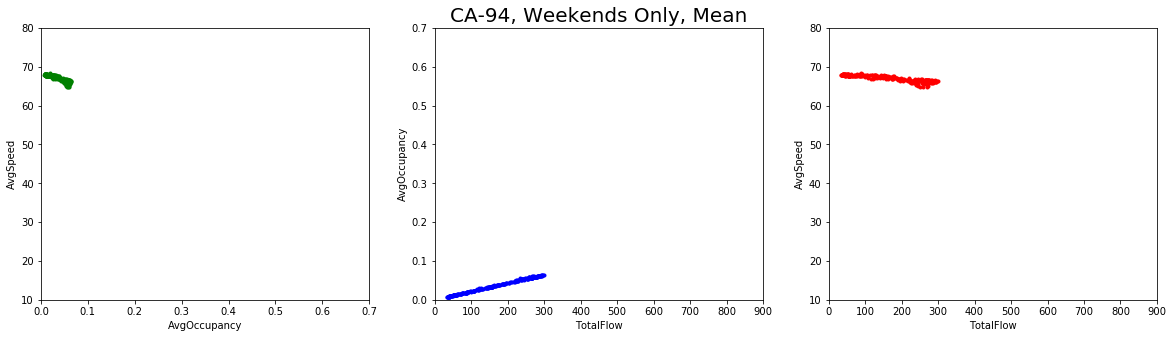

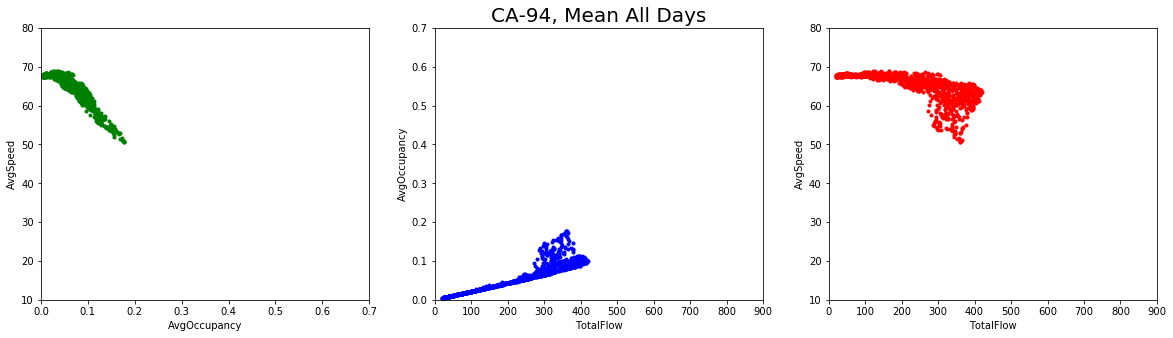

In [19]:
lims_94={
    'x1': (0, 0.7), 'y1': (10, 80),
    'x2': (0, 900), 'y2': (0, 0.7),
    'x3': (0, 900), 'y3': (10, 80)
}

for d in daymap.values():
    small_df = df_94.ix[df_94.Weekday==d,['TotalFlow','AvgOccupancy','AvgSpeed']]
    plot_triple( small_df, 'CA-94, Day of Week: {}'.format(d), lims=lims_94 )

small_df = df_94[ df_94.Weekday.isin(weekdays) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-94, Weekdays Only', lims=lims_94 )
    
small_df = df_94[ df_94.Weekday.isin(weekends) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-94, Weekends Only', lims=lims_94 )

small_df = df_94[ df_94.Weekday.isin(weekdays) ].groupby(['Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-94, Weekdays Only, Mean', lims=lims_94 )

small_df = df_94[ df_94.Weekday.isin(weekends) ].groupby(['Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
plot_triple( small_df, 'CA-94, Weekends Only, Mean', lims=lims_94 )

small_df = df_94.groupby(['Weekday', 'Time']).mean()[['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
small_df.reset_index( inplace=True )
plot_triple( small_df, 'CA-94, Mean All Days', lims=lims_94 )

### CA-54 Data Prep (weekday-only, standardized)

In [20]:
df_standardized = df_54[ df_54.Weekday.isin(weekdays) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
df_standardized = (df_standardized - df_standardized.mean())/df_standardized.std()
df_standardized.shape

(38016, 3)

In [21]:
X = df_standardized

In [22]:
sample_size = 0.75

X, _ = train_test_split( df_standardized, train_size=sample_size, random_state=42 )
X.shape

(28512, 3)

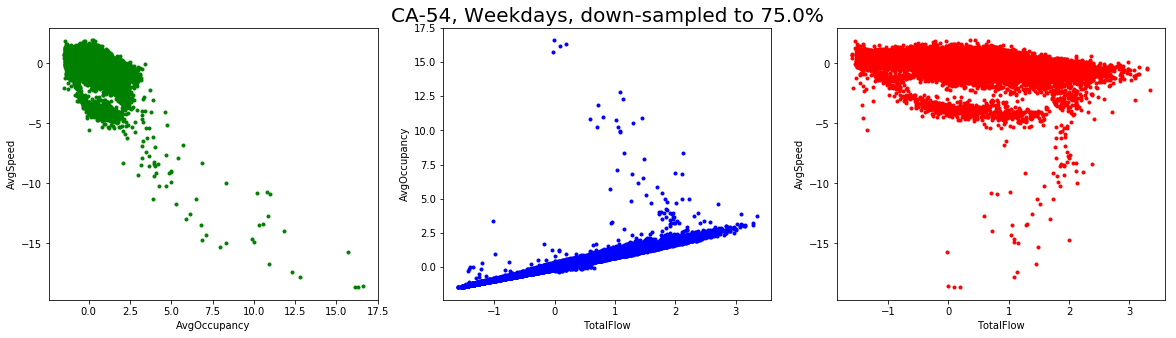

In [23]:
plot_triple( X, 'CA-54, Weekdays, down-sampled to {:.3}%'.format(sample_size*100), setlims=False)

## CA-54 Clustering

In [24]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

def plot_cluster( df, title, y_pred ):
    fig = plt.figure(figsize = (20,5))
    plt.title( title, {'fontsize': 20})

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    ax1.scatter( df['AvgOccupancy'], df['AvgSpeed'], color=colors[y_pred].tolist(), s=10 )
    ax2.scatter( df['TotalFlow'], df['AvgOccupancy'], color=colors[y_pred].tolist(), s=10 )
    ax3.scatter( df['TotalFlow'], df['AvgSpeed'], color=colors[y_pred].tolist(), s=10 )

    #ax1.set_xlim( (0, 0.2)), ax1.set_ylim( (40, 75))
    #ax2.set_xlim( (0, 600)), ax2.set_ylim( (0, 0.7))
    #ax3.set_xlim( (0, 600)), ax3.set_ylim( (40, 75))
    
    ax1.set_xlabel('AvgOccupancy'), ax1.set_ylabel('AvgSpeed')
    ax2.set_xlabel('TotalFlow'), ax2.set_ylabel('AvgOccupancy')
    ax3.set_xlabel('TotalFlow'), ax3.set_ylabel('AvgSpeed')

    plt.show()

### Look at several clustering methods

In [25]:
n_clusters = 2

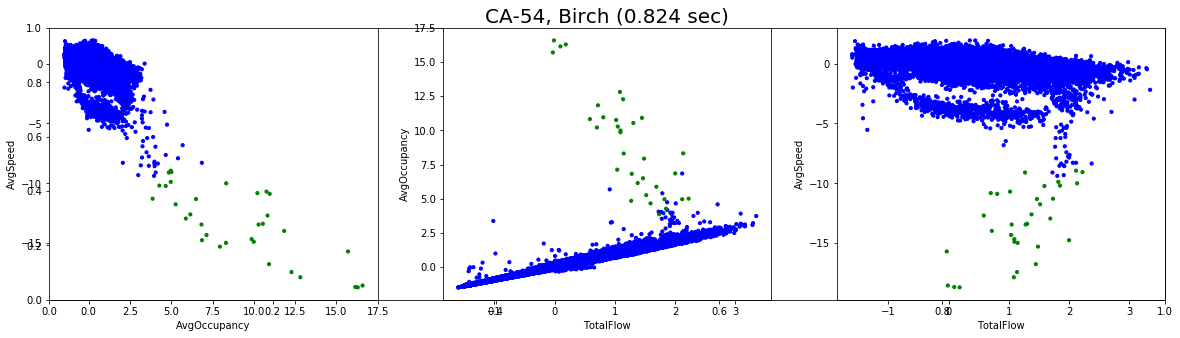

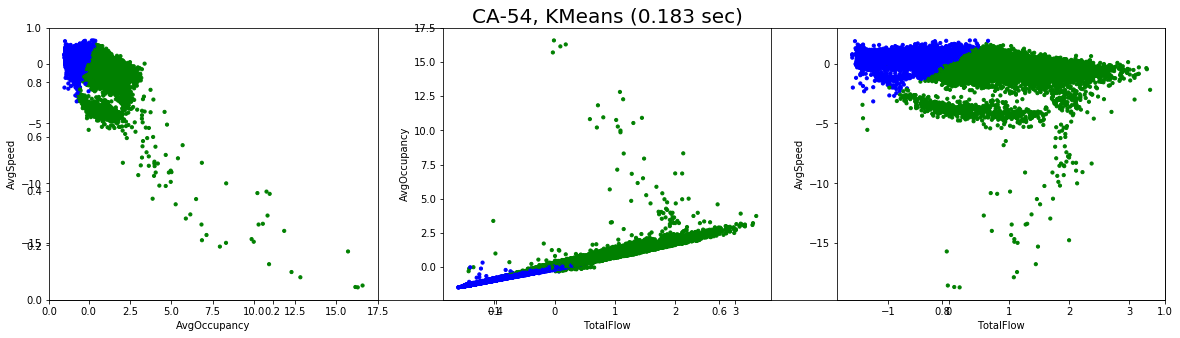

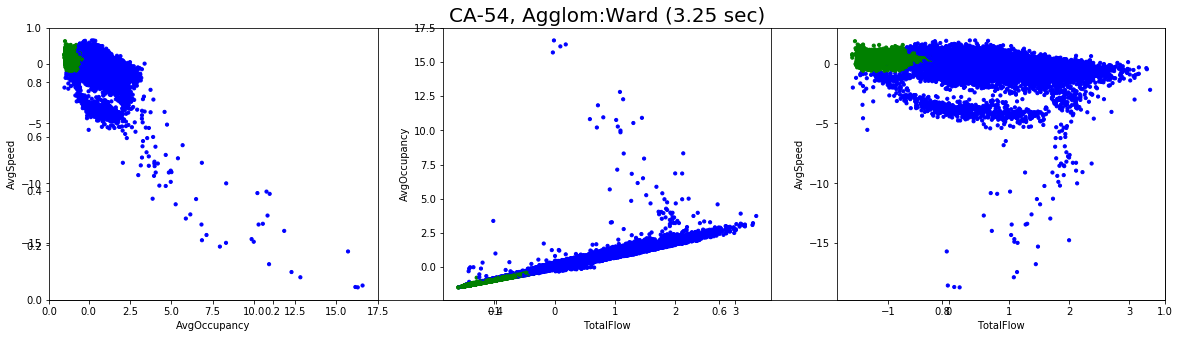

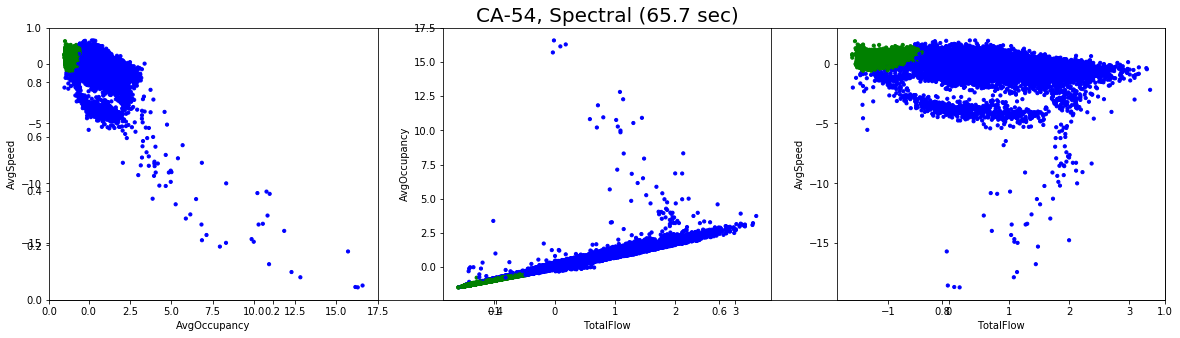

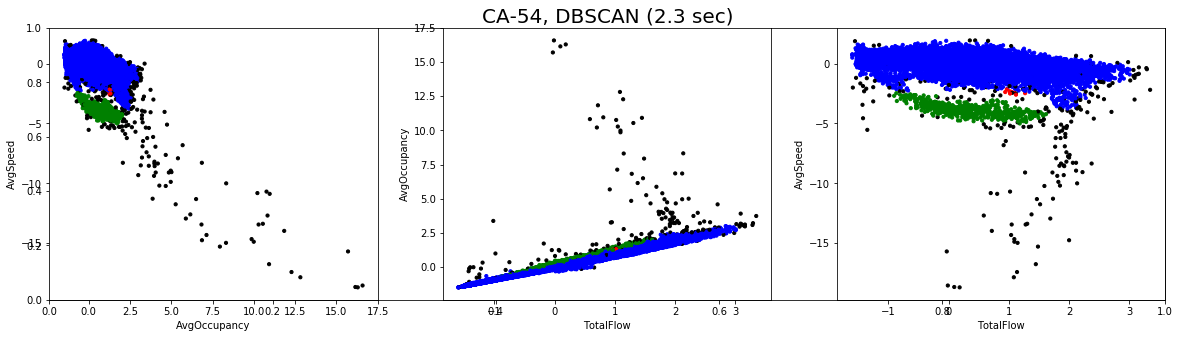

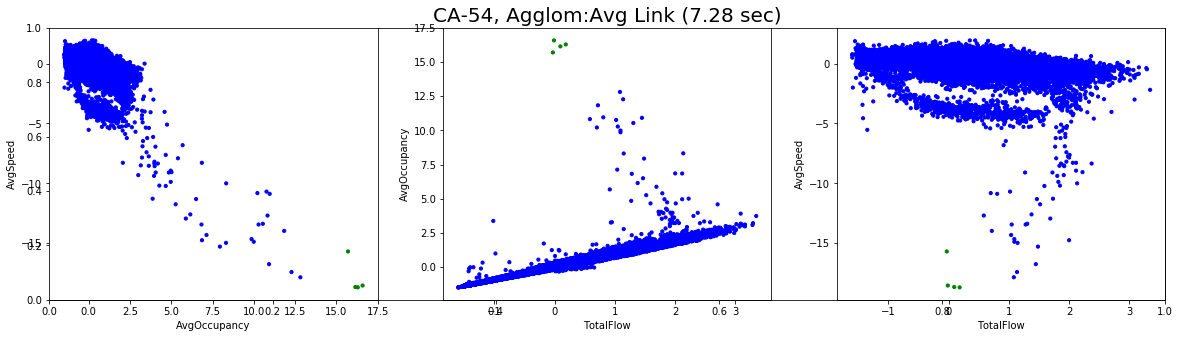

In [26]:
kmeans = cluster.KMeans( n_clusters=n_clusters )

birch = cluster.Birch( n_clusters=n_clusters )

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.2)


average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=n_clusters,
        connectivity=connectivity)

algs = [('Birch', birch ),
        ('KMeans', kmeans),
        ('Agglom:Ward', ward), 
        ('Spectral', spectral),
        ('DBSCAN', dbscan),
        ('Agglom:Avg Link', average_linkage) ]

for alg in algs:
    t0 = time.time()
    y_pred = alg[1].fit_predict( X )
    plot_cluster( X, 'CA-54, {0} ({1:.3} sec)'.format(alg[0], time.time()-t0), y_pred )

#### DBSCAN Exploration (CA-54)

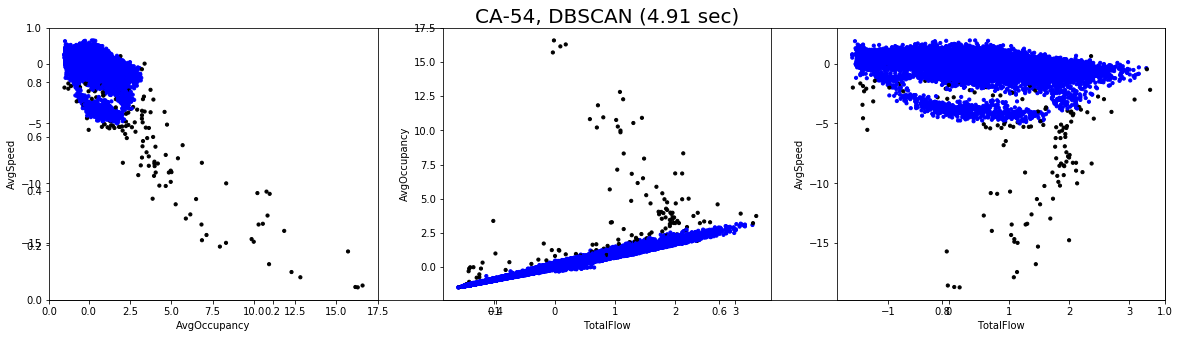

In [27]:
dbscan = cluster.DBSCAN( eps=.3 )

t0 = time.time()
y_pred = dbscan.fit_predict( X )
plot_cluster( X, 'CA-54, {0} ({1:.3} sec)'.format('DBSCAN', time.time()-t0), y_pred )

#### Birch Exploration (CA-54)

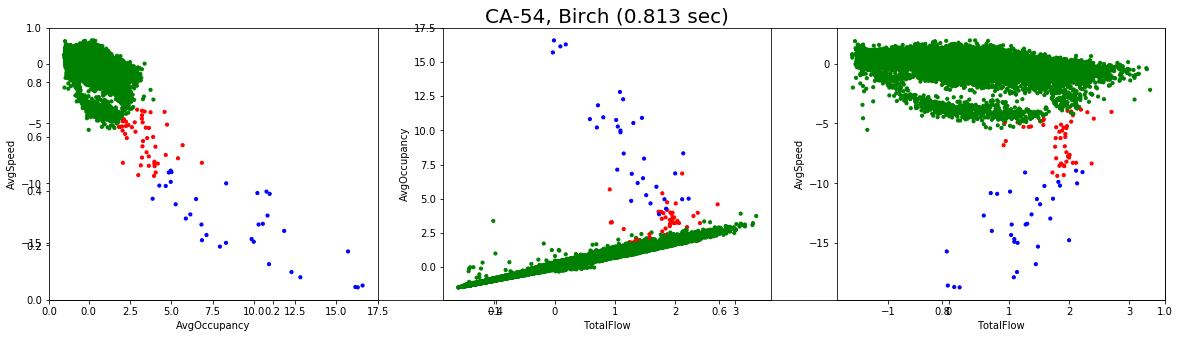

In [28]:
birch = cluster.Birch( n_clusters=3)

t0 = time.time()
y_pred = birch.fit_predict( X )
plot_cluster( X, 'CA-54, {0} ({1:.3} sec)'.format('Birch', time.time()-t0), y_pred )

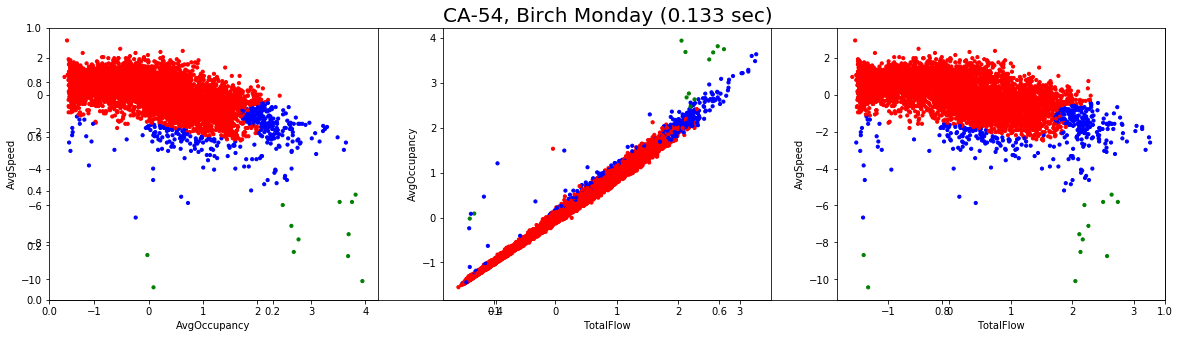

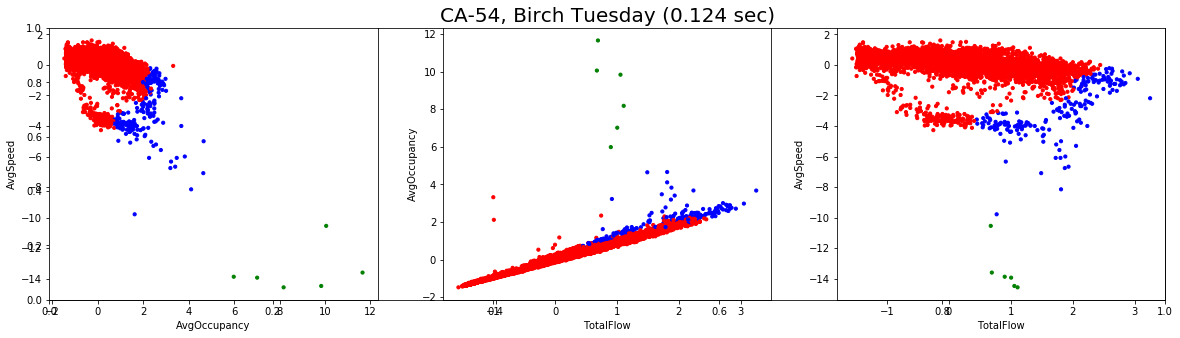

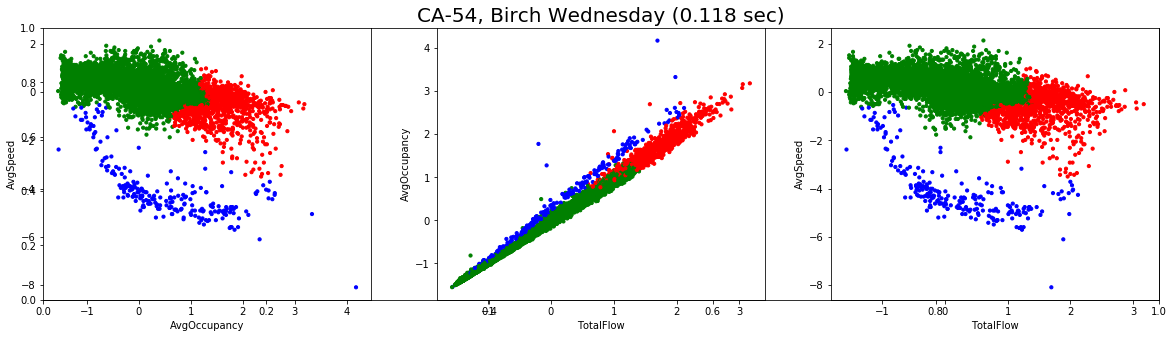

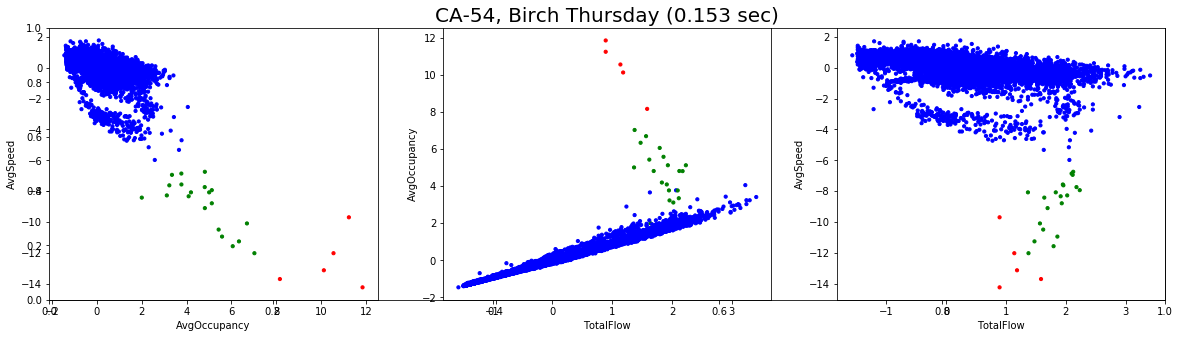

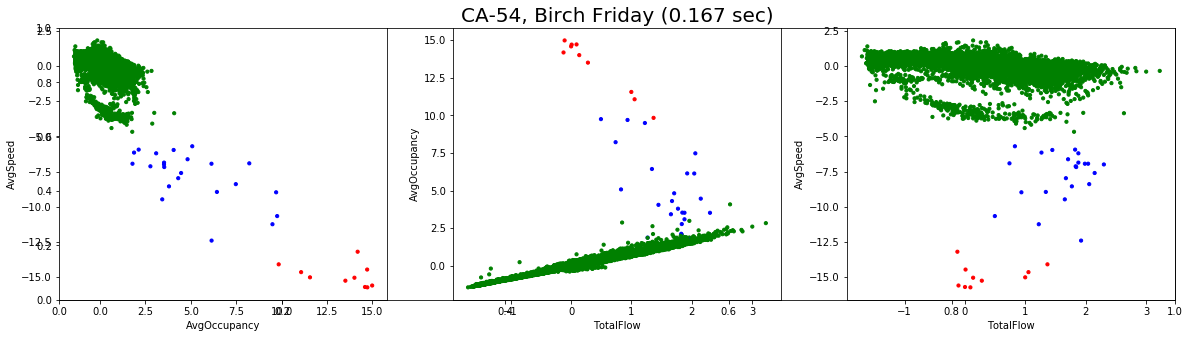

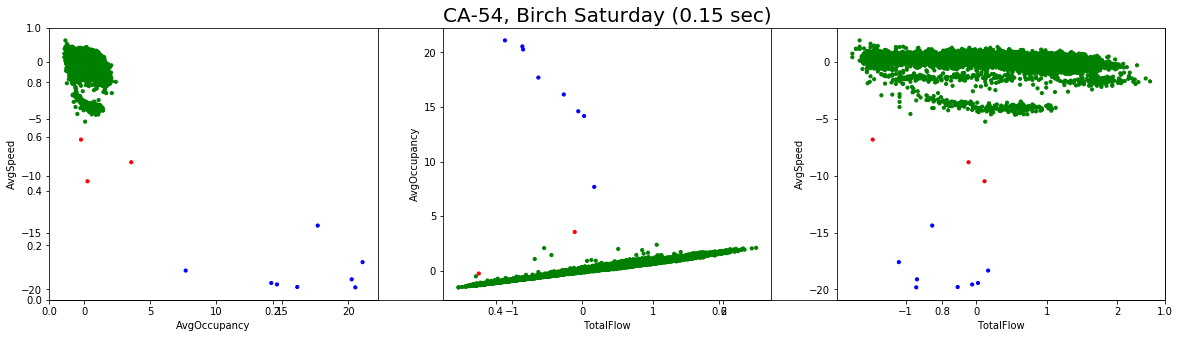

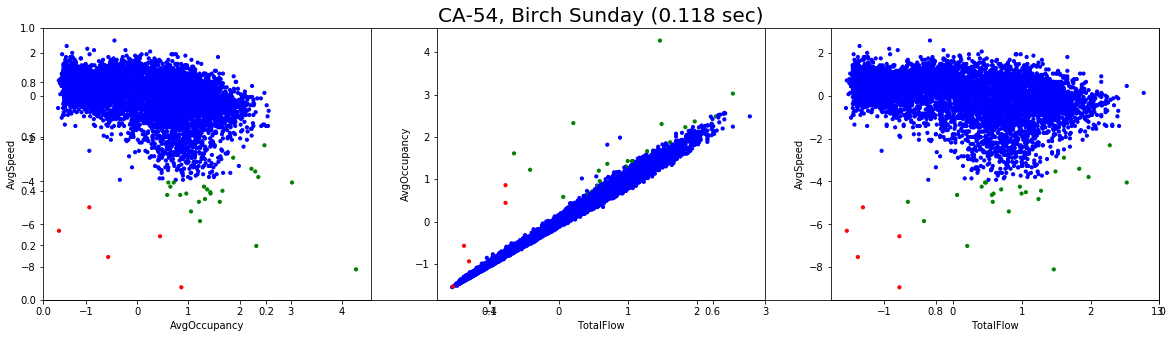

In [29]:
for d in daymap.values():
    X = df_54[ df_54.Weekday==d ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
    X = (X - X.mean())/X.std()

    birch = cluster.Birch( n_clusters=3 )

    t0 = time.time()
    y_pred = birch.fit_predict( X )
    plot_cluster( X, 'CA-54, Birch {0} ({1:.3} sec)'.format(d, time.time()-t0), y_pred )

### CA-94 Data Prep (weekday-only, standardized)

In [30]:
X_orig = df_94[ df_94.Weekday.isin(weekdays) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
X = (X_orig - X_orig.mean())/X_orig.std()
X.shape

(234432, 3)

shape: (11721, 3)


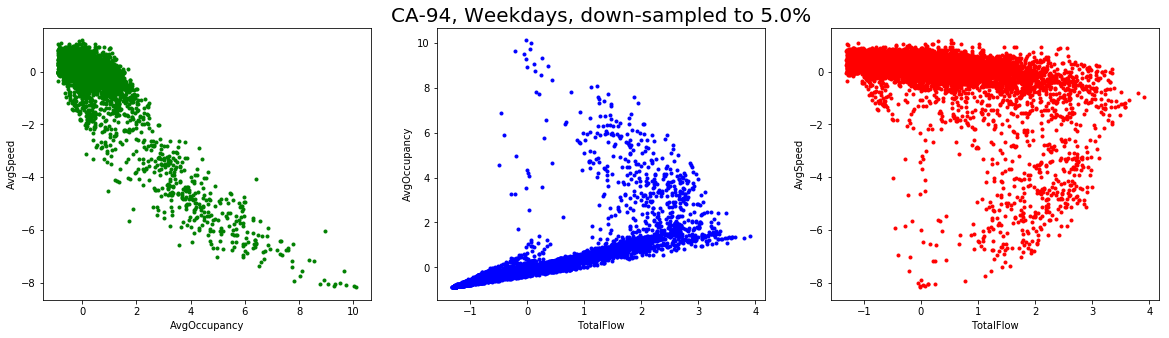

In [31]:
# randomly sample if we need to have a smaller dataset

sample_size = 0.05

X_orig, _ = train_test_split( X_orig, train_size=sample_size, random_state=42 )
print 'shape:', X_orig.shape

X = (X_orig - X_orig.mean())/X_orig.std()

plot_triple( X, 'CA-94, Weekdays, down-sampled to {:.3}%'.format(sample_size*100), setlims=False)

## CA-94 Clustering

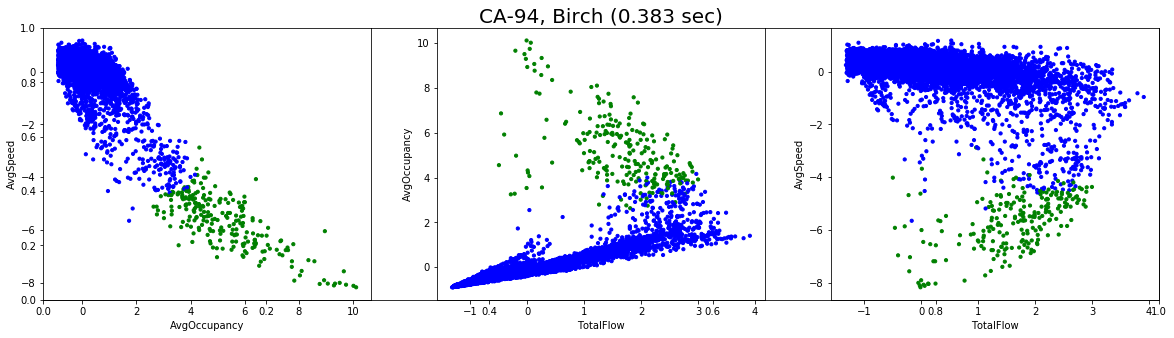

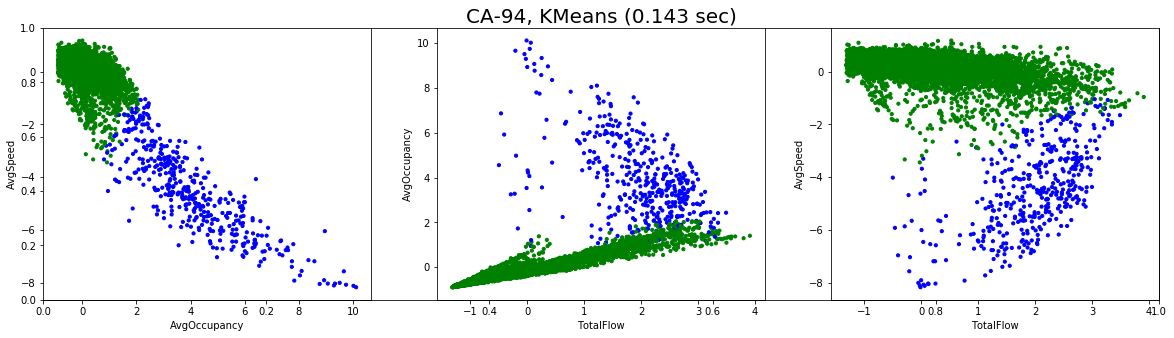

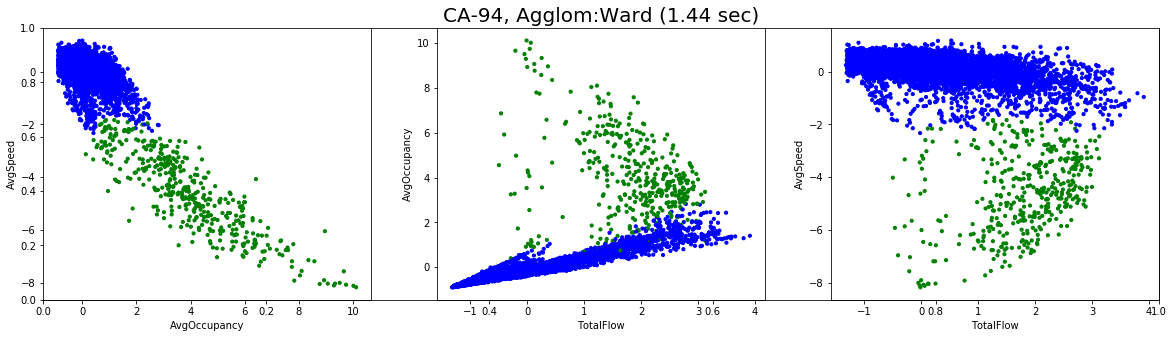

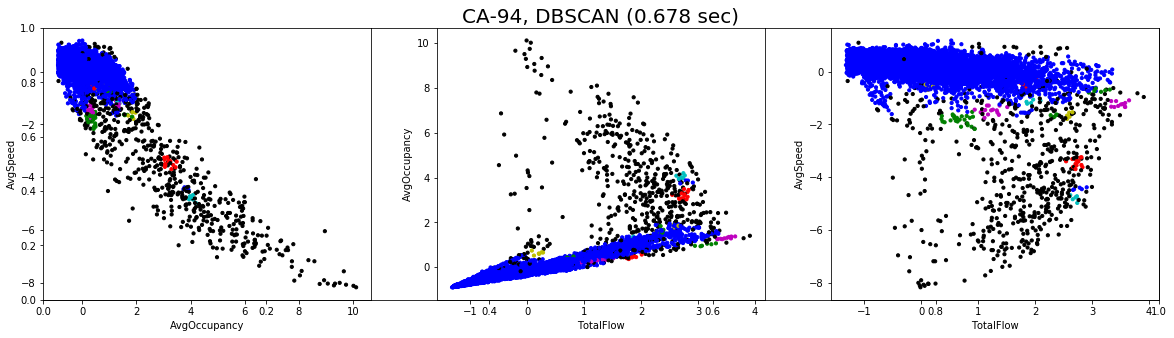

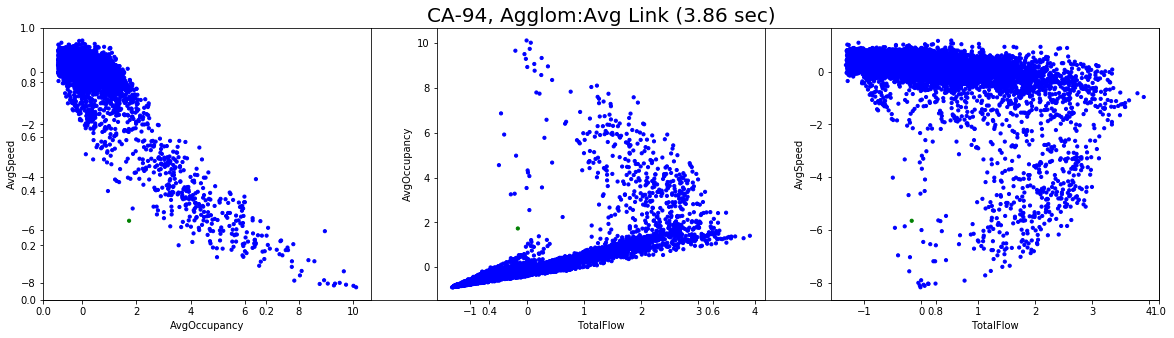

In [32]:
kmeans = cluster.KMeans( n_clusters=n_clusters )

birch = cluster.Birch( n_clusters=n_clusters )

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.2)


average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=n_clusters,
        connectivity=connectivity)

algs = [('Birch', birch ),
        ('KMeans', kmeans),
        ('Agglom:Ward', ward), 
        #('Spectral', spectral),
        ('DBSCAN', dbscan),
        ('Agglom:Avg Link', average_linkage) ]

for alg in algs:
    t0 = time.time()
    y_pred = alg[1].fit_predict( X )
    plot_cluster( X, 'CA-94, {0} ({1:.3} sec)'.format(alg[0], time.time()-t0), y_pred )

#### Birch Exploration (CA-94)

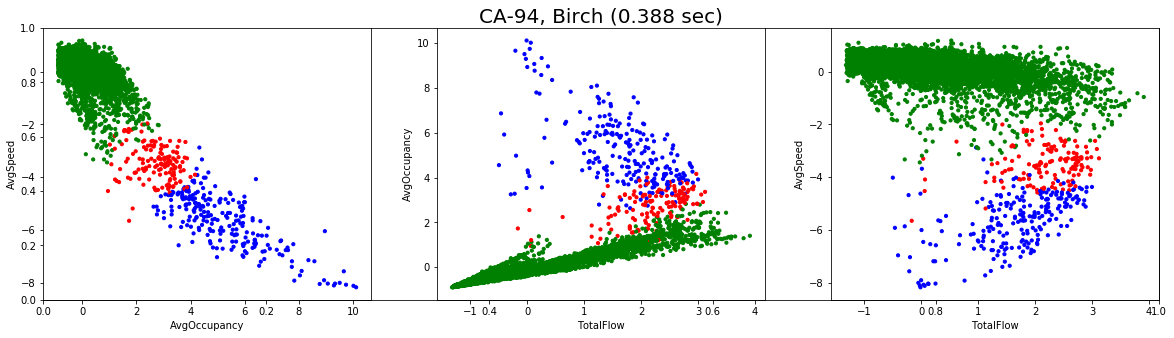

In [33]:
birch = cluster.Birch( n_clusters=3 )

t0 = time.time()
y_pred = birch.fit_predict( X )
plot_cluster( X, 'CA-94, {0} ({1:.3} sec)'.format('Birch', time.time()-t0), y_pred )

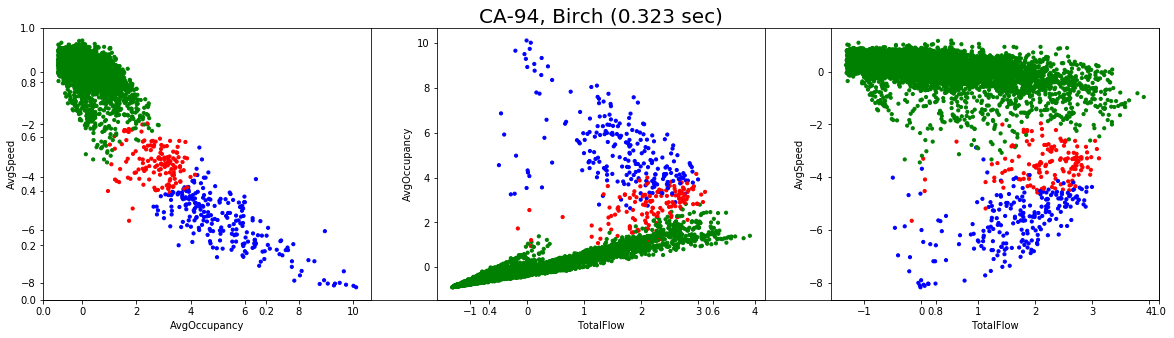

In [34]:
birch = cluster.Birch( n_clusters=3 )

t0 = time.time()
y_pred = birch.fit_predict( X )
plot_cluster( X, 'CA-94, {0} ({1:.3} sec)'.format('Birch', time.time()-t0), y_pred )

#### Birch Exploration (CA-94 model, predict CA-54 data)

In [35]:
X_54 = df_54[ df_54.Weekday.isin(weekdays) ][['TotalFlow', 'AvgOccupancy', 'AvgSpeed']]
X_54 = (X_54 - X_54.mean())/X_54.std()
X_54.shape

(38016, 3)

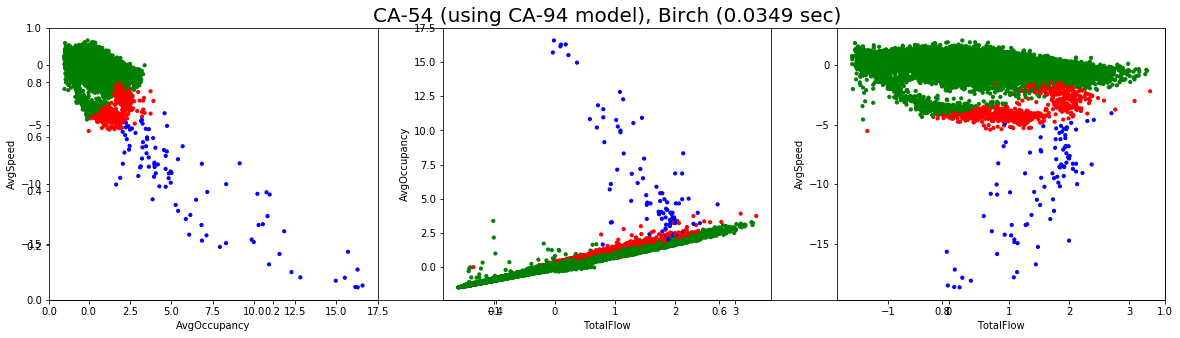

In [36]:
t0 = time.time()
y_pred_54 = birch.predict( X_54 )
plot_cluster( X_54, 'CA-54 (using CA-94 model), {0} ({1:.3} sec)'.format('Birch', time.time()-t0), y_pred_54 )

### Results

Unfortunately, CA-54 seems to be a bit irregular when compared to other highways.  Therefore, while interesting, the cluster analysis of CA-54 may not be of much use.

In contrast, CA-94 exhibits a pattern within the scatter plots that is quite representative of other highways (in the CA highway system).  Accordingly, this clustering provides a much better look at what we'd expect when applied on other highways.

Of the clustering methods explored, two seem to be particularily unsuited for this application: DBSCAN and Agglomerative (average link).  Of the remaining algorithms, the Birch clustering appears to perform the best.

### Conclusions

Birch clustering appears to match the data fairly well.  Additional exploration may be needed to determine if it is a viable approach for classification.

## 3-D Plots for Funsies

#### The matplotlib 3d plot is part of pyplot and doesn't need any additional python packages.  
#### On the other hand, plotly is a whole involved thing (requires an account and python module).

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

#### 3-D Static Matplotlib

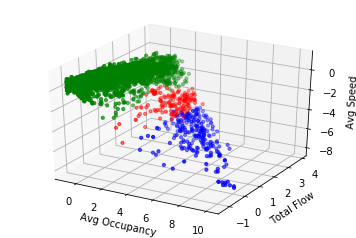

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X.AvgOccupancy
ys = X.TotalFlow
zs = X.AvgSpeed

ax.scatter(xs, ys, zs, c=colors[y_pred].tolist(), s=10 )

ax.set_xlabel('Avg Occupancy')
ax.set_ylabel('Total Flow')
ax.set_zlabel('Avg Speed')

plt.show()

#### 3-D Interactive Plotly

In [40]:
import sys
sys.path.append('~/Vault')
import plotlykeys
plotly_usr, plotly_key = plotlykeys.getkeys()

py.sign_in( plotly_usr, plotly_key )

plotly.tools.set_credentials_file( username=plotly_usr, api_key=plotly_key )
plotly.tools.set_config_file( world_readable=True, sharing='public' )

ImportError: No module named plotlykeys

In [ ]:
# Plot using the original scaling (not standardized)
X = X_orig

In [ ]:
gX = X.iloc[ np.where(y_pred==0) ]
bX = X.iloc[ np.where(y_pred==1) ]
rX = X.iloc[ np.where(y_pred==2) ]

trace1 = go.Scatter3d(
    name='Traffic Type 1',
    x=gX.AvgOccupancy,
    y=gX.TotalFlow,
    z=gX.AvgSpeed,
    mode='markers',
    type = "scatter3d", 
    marker=dict(
    #    size=12,
        color='rgb(0, 127, 0)',
        line=dict(
            color='rgba(0, 127, 0, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    name='Traffic Type 2',
    x=bX.AvgOccupancy,
    y=bX.TotalFlow,
    z=bX.AvgSpeed,
    mode='markers',
    type = "scatter3d", 
    marker=dict(
        color='rgb(0, 0, 127)',
        #size=12,
        #symbol='circle',
        line=dict(
            color='rgba(0, 0, 127, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace3 = go.Scatter3d(
    name='Traffic Type 3',
    x=rX.AvgOccupancy,
    y=rX.TotalFlow,
    z=rX.AvgSpeed,
    mode='markers',
    type= "scatter3d", 
    marker=dict(
        color='rgb(127, 0, 0)',
        #size=12,
        symbol='circle',
        line=dict(
            color='rgba(127, 0, 0, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)
data = [trace1, trace2, trace3]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title='Traffic Clusters',
    scene=go.Scene(
        xaxis=go.XAxis(title='Avg Occupancy'),
        yaxis=go.YAxis(title='Total Flow'),
        zaxis=go.ZAxis(title='Avg Speed')
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='traffic-3d-scatter')